In [26]:
import pandas as pd
import numpy as np
import evds as e
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, month_plot
from arch.unitroot import ADF, KPSS
from pmdarima import auto_arima
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.holtwinters import Holt, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima.model import ARIMA
import pymannkendall as mk
from sklearn.model_selection import TimeSeriesSplit
api = "J26wajoR3H"
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning, module="statsmodels")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

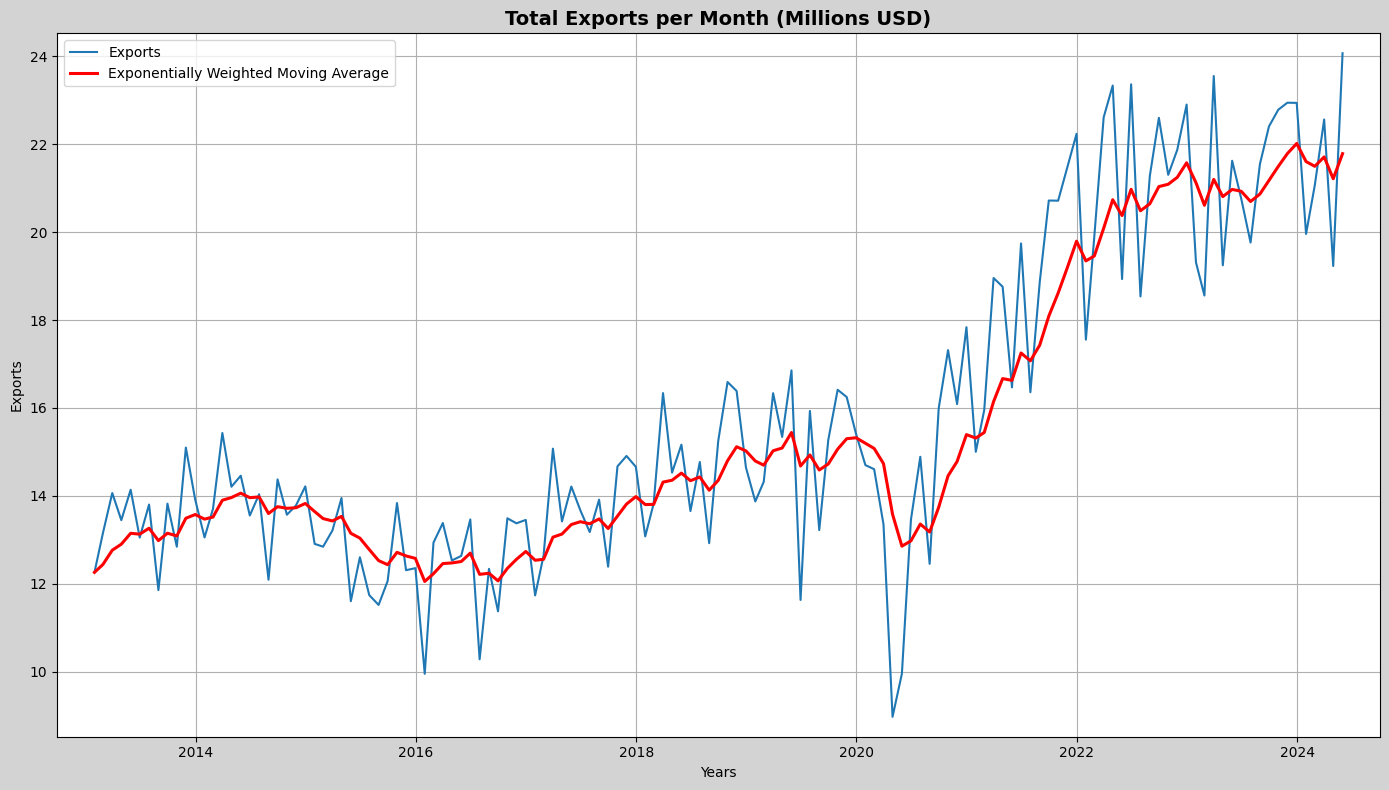

In [57]:
# Get the data from evds

evds = e.evdsAPI(api)
data = evds.get_data(["TP.IHRACATBEC.9999"], startdate="01-01-2013", enddate="01-05-2024", frequency=5)
data = pd.DataFrame(data)
data.rename(columns={"TP_IHRACATBEC_9999" : "Exports"}, inplace=True)
tarih = pd.date_range(start="01-01-2013", periods=len(data), freq="M")
data["Date"] = tarih
data.set_index("Date", inplace=True)
data["Exports"] = data["Exports"] / 1000 # in order to make numbers low
data.drop(columns=["Tarih"], inplace=True)
# Split train test
train, test = data.iloc[:-27], data.iloc[-27:]

# Difference to make the series stationary
train_diff = train.diff().dropna()

# Exponentially Weighted Moving Average
emwa = (data["Exports"]/1000).ewm(alpha=0.2, adjust=False).mean()

# Plot the data 
plt.figure(figsize=(14,8), facecolor="lightgray")
plt.gca().set_facecolor('white')
plt.plot(data["Exports"]/ 1000, label="Exports")
plt.plot(emwa, label="Exponentially Weighted Moving Average", color="red", lw=2.2)
plt.grid()
plt.title("Total Exports per Month (Millions USD)", fontweight="bold", fontsize=14)
plt.xlabel("Years")
plt.ylabel("Exports")
plt.tight_layout()
plt.margins(0.03)
plt.legend()
plt.savefig("./graphs/total_export.png")
plt.show()

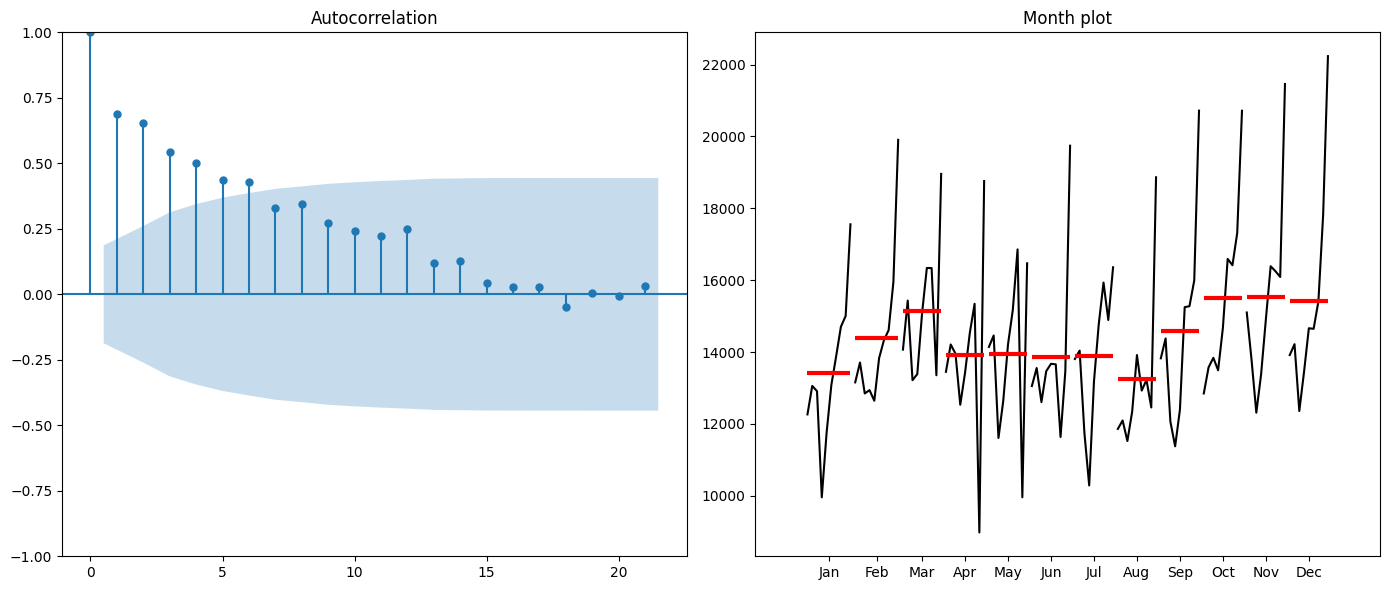

In [59]:
# Auto-correlation and monthly plots

fig,ax = plt.subplots(1,2, figsize=(14,6))
plot_acf(train, ax=ax[0]) # auto-correlation graph
month_plot(train, ax=ax[1])

ax[1].set_title("Month plot")
plt.tight_layout()
plt.savefig("./graphs/acf_month_plot.png")
plt.show()

In [29]:
# ADF and KPSS test for testing stationary

adf = ADF(train) # contains a unit root
kpss = KPSS(train) # contains a unit root
#print(adf)
#print(kpss)

# Same test on 1st order differenced data
adf2 = ADF(train_diff) # weakly stationary
kpss2 = KPSS(train_diff) # weakly stationary
print(adf2)
print(kpss2)

   Augmented Dickey-Fuller Results   
Test Statistic                 -7.096
P-value                         0.000
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: -3.49 (1%), -2.89 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
    KPSS Stationarity Test Results   
Test Statistic                  0.123
P-value                         0.483
Lags                               10
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


In [30]:
# Mann-Kendall Test for determining the trend

mk = mk.original_test(train) # trend='increasing'
print(mk)

Mann_Kendall_Test(trend='increasing', h=True, p=2.093221151966418e-10, z=6.354340881636219, Tau=0.4105087572977481, s=2461.0, var_s=149875.0, slope=39.815707564102546, intercept=11725.35286775641)


In [31]:
# ARIMA model

model1 = auto_arima(train, trace=False, seasonal=False) # ARIMA(0,1,1)
# AIC=3437.7, BIC=3443.0
print(model1.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -961.143
Date:                Tue, 23 Jul 2024   AIC                           1926.286
Time:                        11:09:51   BIC                           1931.669
Sample:                    01-31-2013   HQIC                          1928.469
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4705      0.064     -7.325      0.000      -0.596      -0.345
sigma2      2.521e+06   3.08e+05      8.186      0.000    1.92e+06    3.13e+06
Ljung-Box (L1) (Q):                   0.46   Jarque-

In [32]:
# SARIMA model

# for loop to find the best seasonality parameter
""" for i in range(2,13):
    model_temp = auto_arima(train, trace=False, seasonal=True, m=i)
    print("m: {} --> aic: {}".format(i, model_temp.aic()))
    print("m: {} --> bic: {}\n".format(i, model_temp.bic())) """

model2 = auto_arima(train, trace=False, seasonal=True, m=6)
# AIC=3431.5, BIC=3442.3
print(model2.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  110
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -961.143
Date:                Tue, 23 Jul 2024   AIC                           1926.286
Time:                        11:09:52   BIC                           1931.669
Sample:                    01-31-2013   HQIC                          1928.469
                         - 02-28-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4705      0.064     -7.325      0.000      -0.596      -0.345
sigma2      2.521e+06   3.08e+05      8.186      0.000    1.92e+06    3.13e+06
Ljung-Box (L1) (Q):                   0.46   Jarque-

In [33]:
# Holt model

model3 = Holt(train).fit(optimized=True, use_brute=True)
# AIC=3154.3, BIC=3165.1
print(model3.summary())

                              Holt Model Results                              
Dep. Variable:                Exports   No. Observations:                  110
Model:                           Holt   SSE                      290744076.779
Optimized:                       True   AIC                           1634.622
Trend:                       Additive   BIC                           1645.424
Seasonal:                        None   AICC                          1635.438
Seasonal Periods:                None   Date:                 Tue, 23 Jul 2024
Box-Cox:                        False   Time:                         11:09:52
Box-Cox Coeff.:                  None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.4292857                alpha                 True
smoothing_trend            0.1226531                

In [34]:
# ExponentialSmoothing model

# for loop to find the best seasonality parameter
""" for i in range(2,13):
    model_temp = ExponentialSmoothing(train, trend="add", seasonal="mul", seasonal_periods=i).fit(optimized=True, use_brute=True)
    print("m: {} --> aic: {}".format(i, model_temp.aic))
    print("m: {} --> bic: {}\n".format(i, model_temp.bic)) """

model4 = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=6).fit(optimized=True, use_brute=True)
# AIC=3138.5, BIC=3165.5
print(model4.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                  Exports   No. Observations:                  110
Model:             ExponentialSmoothing   SSE                      225795401.542
Optimized:                         True   AIC                           1618.813
Trend:                   Multiplicative   BIC                           1645.817
Seasonal:                Multiplicative   AICC                          1622.029
Seasonal Periods:                     6   Date:                 Tue, 23 Jul 2024
Box-Cox:                          False   Time:                         11:09:52
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.3939286                alpha                 True
smoothing_trend          

In [60]:
# Calculating error metrics for each model to pick 2 best model

# ARIMA(0,1,1)           ->  AIC=3437.7, BIC=3443.0
# SARIMA(0,1,1)(0,0,2,6) ->  AIC=3431.5, BIC=3442.3
# Holt                   ->  AIC=3154.3, BIC=3165.1
# ExponentialSmoothing   ->  AIC=3138.5, BIC=3165.5 (best model)

def hata(y,tahmin):
    mse = np.round(mean_squared_error(y,tahmin),2)
    rmse = np.round(np.sqrt(mean_squared_error(y,tahmin)),2)
    mae = np.round(mean_absolute_error(y, tahmin),2)
    return mse, rmse, mae

mse, mae, rmse = [], [], []

tscv = TimeSeriesSplit(n_splits=5)

for train_index,test_index in tscv.split(train):
    
    train_data, test_data = train.iloc[train_index], train.iloc[test_index]
    model = auto_arima(train_data, trace=False, seasonal=False)
    tahmin = model.predict(len(test_data))
    hatason = hata(test_data, tahmin)
    mse.append(hatason[0])
    rmse.append(hatason[1])
    mae.append(hatason[2])
print("ARIMA Model MSE: {} RMSE: {} MAE: {}\n".format(np.round(np.mean(mse),2),np.round(np.mean(rmse),2),np.round(np.mean(mae),2)))

for train_index,test_index in tscv.split(train):
    
    train_data, test_data = train.iloc[train_index], train.iloc[test_index]
    model = auto_arima(train_data, trace=False, seasonal=True, m=6)
    tahmin = model.predict(len(test_data))
    hatason = hata(test_data, tahmin)
    mse.append(hatason[0])
    rmse.append(hatason[1])
    mae.append(hatason[2])
print("SARIMA Model MSE: {} RMSE: {} MAE: {}\n".format(np.round(np.mean(mse),2),np.round(np.mean(rmse),2),np.round(np.mean(mae),2)))

for train_index,test_index in tscv.split(train):
    
    train_data, test_data = train.iloc[train_index], train.iloc[test_index]
    model = Holt(train_data).fit(optimized=True, use_brute=True)
    tahmin = model.forecast(len(test_data))
    hatason = hata(test_data, tahmin)
    mse.append(hatason[0])
    rmse.append(hatason[1])
    mae.append(hatason[2])
print("Holt Model MSE: {} RMSE: {} MAE: {}\n".format(np.round(np.mean(mse),2),np.round(np.mean(rmse),2),np.round(np.mean(mae),2)))

for train_index,test_index in tscv.split(train):
    
    train_data, test_data = train.iloc[train_index], train.iloc[test_index]
    model = ExponentialSmoothing(train_data, trend="mul", seasonal="mul", seasonal_periods=6).fit(optimized=True, use_brute=True)
    tahmin = model.forecast(len(test_data))
    hatason = hata(test_data, tahmin)
    mse.append(hatason[0])
    rmse.append(hatason[1])
    mae.append(hatason[2])
print("Holt Winters Model MSE: {} RMSE: {} MAE: {}".format(np.round(np.mean(mse),2),np.round(np.mean(rmse),2),np.round(np.mean(mae),2)))

"""
ARIMA Model         MSE: 7561536.7  RMSE: 2341.4 MAE: 1992.5  (best model)

SARIMA Model        MSE: 13499893.9 RMSE: 2774.1 MAE: 2404.3

Holt Model          MSE: 16832035.1 RMSE: 3149.8 MAE: 2777.3

Holt Winters Model  MSE: 16704024.7 RMSE: 3217.1 MAE: 2809.7
"""

ARIMA Model MSE: 7561536.69 RMSE: 2341.43 MAE: 1992.5

SARIMA Model MSE: 13499893.86 RMSE: 2774.07 MAE: 2404.32

Holt Model MSE: 16832035.08 RMSE: 3149.75 MAE: 2777.33



C:\Users\okkes\AppData\Roaming\Python\Python311\site-packages\statsmodels\tsa\holtwinters\model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


Holt Winters Model MSE: 16704024.73 RMSE: 3217.07 MAE: 2809.69


'\nARIMA Model         MSE: 7561536.7  RMSE: 2341.4 MAE: 1992.5  (best model)\n\nSARIMA Model        MSE: 13499893.9 RMSE: 2774.1 MAE: 2404.3\n\nHolt Model          MSE: 16832035.1 RMSE: 3149.8 MAE: 2777.3\n\nHolt Winters Model  MSE: 16704024.7 RMSE: 3217.1 MAE: 2809.7\n'

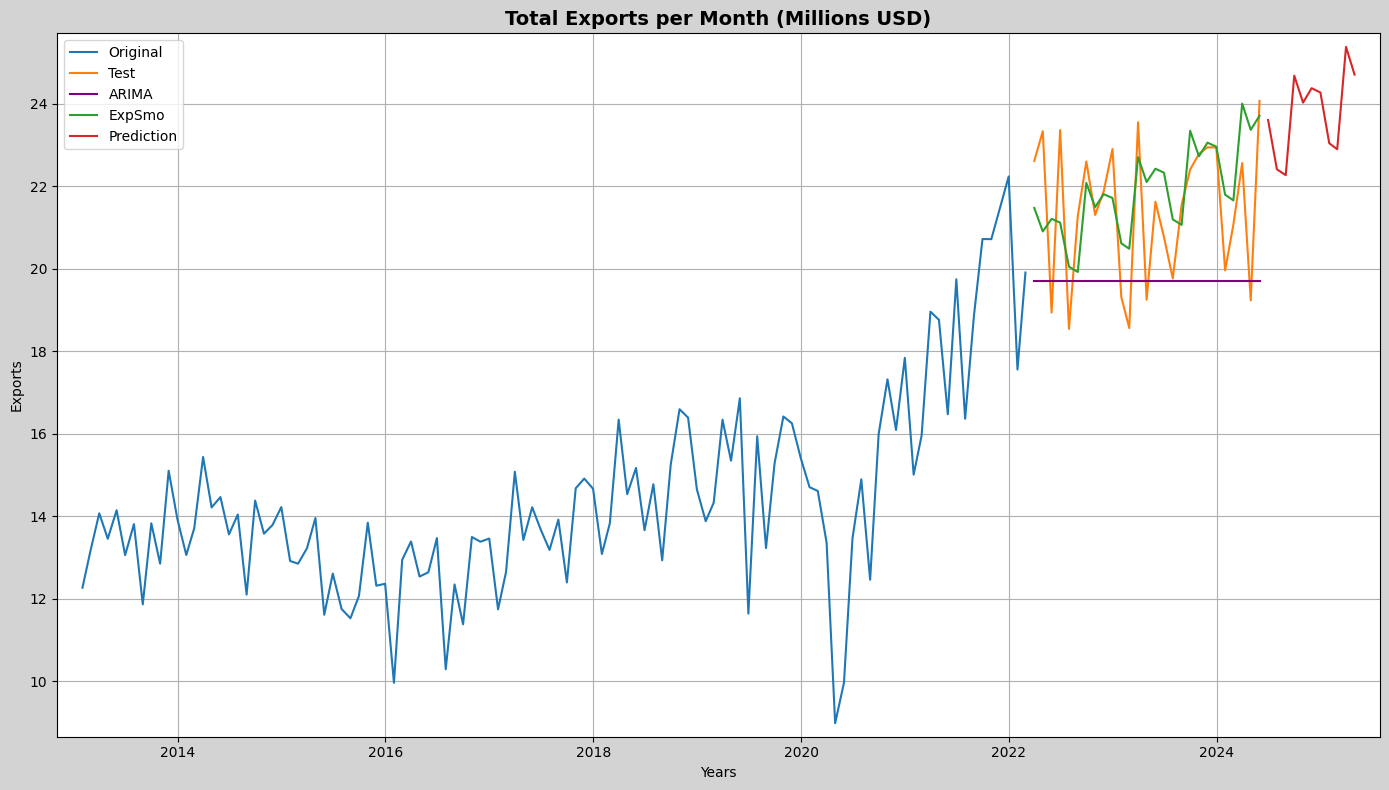

In [64]:
# Predictions on the test data

tahmin1 = model1.predict(start=test.index[0], n_periods=27)/1000

tahmin4 = model4.predict(start=test.index[0], end=test.index[-1])/1000

prediction_dates = pd.date_range(test.index[-1], periods=12, freq="M")[1:]
real_prediction = model4.predict(start=prediction_dates[0], end=prediction_dates[-1])/1000

plt.figure(figsize=(14,8), facecolor="lightgray")
plt.gca().set_facecolor('white')
plt.plot(train/1000, label="Original")
plt.plot(test/1000, label="Test")
plt.plot(tahmin1, label="ARIMA", color="purple")
plt.plot(tahmin4, label="ExpSmo")
plt.plot(real_prediction, label="Prediction")
plt.title("Total Exports per Month (Millions USD)", fontweight="bold", fontsize=14)
plt.xlabel("Years")
plt.ylabel("Exports")
plt.legend()
plt.grid()
plt.margins(0.02)
plt.tight_layout()
plt.savefig("./graphs/total_export_predictions.png")
plt.show()